# RNN
 

In [1]:
import pandas as pd
import numpy as np
import xarray as xr

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

Считываем файл burea.csv, т.к. он содержит информацию связи SK_ID_CURR (заявки, для которой идет предсказание) и записей SK_ID_BUREAU, о которых есть помесячная информация в burea_balance

In [31]:
# bur = pd.read_csv('/kaggle/input/home-credit-default-risk/bureau.csv')
bur = pd.read_csv('home-credit-default-risk/bureau.csv')

bur_id_map = bur.groupby('SK_ID_BUREAU')['SK_ID_CURR'].min().astype(int) # тут не важно, т.к. только один айдишник
bur.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [13]:
bur.loc[bur['SK_ID_CURR'].isin(train_ids)].shape

(523839, 17)

In [5]:
bur.shape

(1716428, 17)

In [4]:
bur['SK_ID_CURR'].nunique(), bur['SK_ID_BUREAU'].nunique()

(305811, 1716428)

In [10]:
1079273 / 1716428

0.6287901385901419

In [4]:
bur['CREDIT_ACTIVE'].value_counts()

CREDIT_ACTIVE
Closed      1079273
Active       630607
Sold           6527
Bad debt         21
Name: count, dtype: int64

In [2]:
# ttt = pd.read_csv('/kaggle/input/home-credit-default-risk/bureau_balance.csv')
ttt = pd.read_csv('home-credit-default-risk/bureau_balance.csv')
ttt.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [47]:
ttt.STATUS.unique()

array(['C', '0', 'X', '1', '2', '3', '5', '4'], dtype=object)

In [58]:
bur_bal.groupby('SK_ID_CURR')[['SK_ID_BUREAU', 'STATUS', 'MONTHS_BALANCE']].nunique().sort_values(by='STATUS', ascending=False)

,SK_ID_BUREAU,STATUS,MONTHS_BALANCE
SK_ID_CURR,,,
127648,13,8,90
221082,12,8,78
244540,3,8,42
365965,6,8,63
287208,4,8,91
...,...,...,...
294249,1,1,8
172468,4,1,12
428904,1,1,6


In [76]:
bur_bal[bur_bal['SK_ID_CURR'] == 287208]['SK_ID_BUREAU'].unique()

array([5765186, 5765187, 5765188, 5765189])

In [83]:
bur_bal[bur_bal['SK_ID_BUREAU'] == 5765186].iloc[62:72]

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS,STATUS_COMPLETE,STATUS_X,STATUS_DPD,SK_ID_CURR
17453238,5765186,-62,C,1,0,-1,287208
17453239,5765186,-63,5,0,0,5,287208
17453240,5765186,-64,5,0,0,5,287208
17453241,5765186,-65,5,0,0,5,287208
17453242,5765186,-66,5,0,0,5,287208
17453243,5765186,-67,5,0,0,5,287208
17453244,5765186,-68,5,0,0,5,287208
17453245,5765186,-69,4,0,0,4,287208
17453246,5765186,-70,4,0,0,4,287208
17453247,5765186,-71,5,0,0,5,287208


In [84]:
ttt[ttt['SK_ID_BUREAU'] == 5765186].iloc[62:72]

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
17453238,5765186,-62,C
17453239,5765186,-63,5
17453240,5765186,-64,5
17453241,5765186,-65,5
17453242,5765186,-66,5
17453243,5765186,-67,5
17453244,5765186,-68,5
17453245,5765186,-69,4
17453246,5765186,-70,4
17453247,5765186,-71,5


In [61]:
ttt[ttt['SK_ID_BUREAU'] == 6388232].iloc[10:20]

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS


In [26]:
ttt.groupby('SK_ID_BUREAU')['STATUS'].nunique().sort_values(ascending=False)

SK_ID_BUREAU
5050953    8
6391907    8
6070697    8
6492033    8
5491322    8
          ..
5742905    1
5742904    1
6409361    1
5742903    1
6061126    1
Name: STATUS, Length: 817395, dtype: int64

In [17]:
ttt.MONTHS_BALANCE.value_counts()

MONTHS_BALANCE
-1     622601
-2     619243
-3     615080
 0     610965
-4     609138
        ...  
-92     57300
-93     53535
-94     49965
-95     46542
-96     43147
Name: count, Length: 97, dtype: int64

In [16]:
ttt.shape

(27299925, 3)

###  Произвожу специальный OHE

Не до конца понимаю нужно ли выделять в отдельную колонку статус оплаты без просрочки. Т.к. остальные статусы оплат по смыслу отражают совсем другое (нет информации и закрытие кредита), а это значение статуса нет. Поэтому первый вариант без выделение в отдельный статус: 

In [32]:
# bur_bal = pd.read_csv('/kaggle/input/home-credit-default-risk/bureau_balance.csv')
bur_bal = pd.read_csv('home-credit-default-risk/bureau_balance.csv')


bur_bal['STATUS_COMPLETE'] = 0
bur_bal.loc[bur_bal['STATUS'] == 'C', 'STATUS_COMPLETE'] = 1

bur_bal['STATUS_X'] = 0
bur_bal.loc[bur_bal['STATUS'] == 'X', 'STATUS_X'] = 1

bur_bal['STATUS_DPD'] = '-1'
bur_bal.loc[bur_bal['STATUS'].isin(['0','1','2','3','4','5']), 'STATUS_DPD'] = bur_bal['STATUS']
bur_bal['STATUS_DPD'] = bur_bal['STATUS_DPD'].astype('int8')

bur_bal['SK_ID_CURR'] = bur_bal['SK_ID_BUREAU'].map(bur_id_map)
print(bur_bal.shape)
bur_bal = bur_bal.loc[bur_bal['SK_ID_CURR'].notna()]
print(bur_bal.shape)
bur_bal['SK_ID_CURR'] = bur_bal['SK_ID_CURR'].astype('int')
bur_bal.head()

(27299925, 7)
(24179741, 7)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS,STATUS_COMPLETE,STATUS_X,STATUS_DPD,SK_ID_CURR
0,5715448,0,C,1,0,-1,380361
1,5715448,-1,C,1,0,-1,380361
2,5715448,-2,C,1,0,-1,380361
3,5715448,-3,C,1,0,-1,380361
4,5715448,-4,C,1,0,-1,380361


Выделение оплаты без просрочки отдельной колонкой (STATUS_PIT - paid in time): 

In [35]:
bur_bal2 = bur_bal.copy()

# перезаписываю все записи и ставлю для пропусков 0
bur_bal2['STATUS_DPD'] = '0'
bur_bal2.loc[bur_bal2['STATUS'].isin(['1','2','3','4','5']), 'STATUS_DPD'] = bur_bal2['STATUS']
bur_bal2['STATUS_DPD'] = bur_bal2['STATUS_DPD'].astype('int8')

bur_bal2['STATUS_PIT'] = '0'
bur_bal2.loc[bur_bal2['STATUS'] == '0', 'STATUS_PIT'] = '1'
bur_bal2['STATUS_PIT'] = bur_bal2['STATUS_PIT'].astype('int8')

bur_bal2.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS,STATUS_COMPLETE,STATUS_X,STATUS_DPD,SK_ID_CURR,STATUS_PIT
0,5715448,0,C,1,0,0,380361,0
1,5715448,-1,C,1,0,0,380361,0
2,5715448,-2,C,1,0,0,380361,0
3,5715448,-3,C,1,0,0,380361,0
4,5715448,-4,C,1,0,0,380361,0


In [5]:
bubl2 = pd.read_csv('/kaggle/input/home-credit-default-risk/bureau_balance.csv')
bubl2['STATUS_COMPLETE'] = 0
bubl2['STATUS_COMPLETE'].loc[bubl2['STATUS']=='C'] = 1
bubl2['STATUS_X'] = 0
bubl2['STATUS_X'].loc[bubl2['STATUS']=='X'] = 1
bubl2['STATUS_DPD'] = -1
bubl2['STATUS_DPD'].loc[bubl2['STATUS'].isin(['1','2','3','4','5'])] = bubl2['STATUS']
bubl2['STATUS_DPD'] = bubl2['STATUS_DPD'].astype('int32')
bubl2['SK_ID_CURR'] = bubl2['SK_ID_BUREAU'].map(buro_id_map)
bubl2 = bubl.loc[bubl2['SK_ID_CURR'].notna()]
bubl2['SK_ID_CURR'] = bubl['SK_ID_CURR'].astype('int')
bubl2.head()

/tmp/ipykernel_34/2186298710.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  bubl2['STATUS_COMPLETE'].loc[bubl2['STATUS']=='C'] = 1
/tmp/ipykernel_34/2186298710.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

NameError: name 'buro_id_map' is not defined

In [36]:
# app_df = pd.read_csv('/kaggle/input/home-credit-default-risk/application_train.csv',usecols=['SK_ID_CURR','TARGET'])
# test_df = pd.read_csv('/kaggle/input/home-credit-default-risk/application_test.csv',usecols=['SK_ID_CURR'])

app_df = pd.read_csv('home-credit-default-risk/application_train.csv',usecols=['SK_ID_CURR','TARGET'])
test_df = pd.read_csv('home-credit-default-risk/application_test.csv',usecols=['SK_ID_CURR'])
app_df.shape, test_df.shape

((307511, 2), (48744, 1))

Read target from main table.

In [37]:
app_df.loc[app_df['SK_ID_CURR'].isin(bur_bal.SK_ID_CURR), 'SK_ID_CURR']

0         100002
7         100010
15        100019
27        100032
28        100033
           ...  
307500    456244
307503    456247
307508    456253
307509    456254
307510    456255
Name: SK_ID_CURR, Length: 92231, dtype: int64

In [39]:
train_ids = app_df.loc[app_df['SK_ID_CURR'].isin(bur_bal.SK_ID_CURR), 'SK_ID_CURR']
test_ids = test_df.loc[test_df['SK_ID_CURR'].isin(bur_bal.SK_ID_CURR), 'SK_ID_CURR']
print(train_ids.shape, test_ids.shape)

# статус 0 в DPD
bur_bal_train = bur_bal.loc[bur_bal['SK_ID_CURR'].isin(train_ids)]
bur_bal_test = bur_bal.loc[bur_bal['SK_ID_CURR'].isin(test_ids)]

# статус 0 в PIT
bur_bal_train2 = bur_bal2.loc[bur_bal2['SK_ID_CURR'].isin(train_ids)]
bur_bal_test2 = bur_bal2.loc[bur_bal2['SK_ID_CURR'].isin(test_ids)]

(92231,) (42311,)


In [40]:
bur_bal_train['SK_ID_CURR'].nunique() / 307511

0.29992748226892696

In [41]:
import copy

num_aggregations = {
    'SK_ID_BUREAU' : ['count'],
    'STATUS_COMPLETE': ['sum'],
    'STATUS_X': ['sum'],
    'STATUS_DPD': ['min', 'median', 'mean', 'max', 'sum'],
}

bur_bal_train = bur_bal_train.groupby(['SK_ID_CURR','MONTHS_BALANCE']).agg(num_aggregations)
bur_bal_test = bur_bal_test.groupby(['SK_ID_CURR','MONTHS_BALANCE']).agg(num_aggregations)

num_aggregations2 = copy.deepcopy(num_aggregations)
num_aggregations2['STATUS_PIT'] = ['min','mean', 'sum']

bur_bal_train2 = bur_bal_train2.groupby(['SK_ID_CURR','MONTHS_BALANCE']).agg(num_aggregations2)
bur_bal_test2 = bur_bal_test2.groupby(['SK_ID_CURR','MONTHS_BALANCE']).agg(num_aggregations2)
# bubl_test.head()

In [42]:
bur_bal_train.tail()

SK_ID_BUREAU STATUS_COMPLETE STATUS_X STATUS_DPD  \
                                 count             sum      sum        min   
SK_ID_CURR MONTHS_BALANCE                                                    
456255     -4                        8               6        1         -1   
           -3                        8               6        0         -1   
           -2                        8               8        0         -1   
           -1                        8               8        0         -1   
            0                        7               7        0         -1   

                                                 
                          median   mean max sum  
SK_ID_CURR MONTHS_BALANCE                        
456255     -4               -1.0 -0.875   0  -7  
           -3               -1.0 -0.750   0  -6  
           -2               -1.0 -1.000  -1  -8  
           -1               -1.0 -1.000  -1  -8  
            0               -1.0 -1.000  -1  -7

In [87]:
bur_bal_test.loc[287208].sort_values(by='MONTHS_BALANCE', ascending=False).iloc[62:72]

SK_ID_BUREAU STATUS_COMPLETE STATUS_X STATUS_DPD              \
                      count             sum      sum        min median mean   
MONTHS_BALANCE                                                                
-62                       2               1        0         -1   -0.5 -0.5   
-63                       2               0        0          0    2.5  2.5   
-64                       2               0        0          0    2.5  2.5   
-65                       2               0        0          0    2.5  2.5   
-66                       2               0        0          0    2.5  2.5   
-67                       2               0        0          0    2.5  2.5   
-68                       2               0        0          0    2.5  2.5   
-69                       1               0        0          4    4.0  4.0   
-70                       1               0        0          4    4.0  4.0   
-71                       1               0        0          5    5.0  5.0   

                        
               max sum  
MONTHS_BALANCE          
-62              0  -1  
-63              5   5  
-64              5   5  
-65              5   5  
-66              5   5  
-67              5   5  
-68              5   5  
-69              4   4  
-70              4   4  
-71              5   5

Убираем двух этажные индексы 

In [10]:
bur_bal_train.columns = pd.Index([elem[0] + "_" + elem[1].upper() for elem in bur_bal_train.columns.tolist()])
bur_bal_test.columns = pd.Index([elem[0] + "_" + elem[1].upper() for elem in bur_bal_test.columns.tolist()])

bur_bal_train2.columns = pd.Index([elem[0] + "_" + elem[1].upper() for elem in bur_bal_train2.columns.tolist()])
bur_bal_test2.columns = pd.Index([elem[0] + "_" + elem[1].upper() for elem in bur_bal_test2.columns.tolist()])

bur_bal_test2.head()

SK_ID_BUREAU_COUNT  STATUS_COMPLETE_SUM  \
SK_ID_CURR MONTHS_BALANCE                                            
100001     -51                              1                    0   
           -50                              1                    0   
           -49                              1                    0   
           -48                              1                    0   
           -47                              1                    0   

                           STATUS_X_SUM  STATUS_DPD_MIN  STATUS_DPD_MEDIAN  \
SK_ID_CURR MONTHS_BALANCE                                                    
100001     -51                        1               0                0.0   
           -50                        1               0                0.0   
           -49                        1               0                0.0   
           -48                        1               0                0.0   
           -47                        1               0                0.0   

                           STATUS_DPD_MEAN  STATUS_DPD_MAX  STATUS_DPD_SUM  \
SK_ID_CURR MONTHS_BALANCE                                                    
100001     -51                         0.0               0               0   
           -50                         0.0               0               0   
           -49                         0.0               0               0   
           -48                         0.0               0               0   
           -47                         0.0               0               0   

                           STATUS_PIT_MIN  STATUS_PIT_MEAN  STATUS_PIT_SUM  
SK_ID_CURR MONTHS_BALANCE                                                   
100001     -51                          0              0.0               0  
           -50                          0              0.0               0  
           -49                          0              0.0               0  
           -48                          0              0.0               0  
           -47                          0              0.0               0

In [11]:
# train
train_x = xr.Dataset.from_dataframe(bur_bal_train).to_array().values
train_x = train_x.swapaxes(0, 1).swapaxes(1, 2)
train_x[np.isnan(train_x)] = -42

# train_y = app_df.loc[app_df.SK_ID_CURR.isin(train_ids), 'TARGET']
train_y = app_df.loc[app_df.SK_ID_CURR.isin(train_ids), ['TARGET', 'SK_ID_CURR']].set_index('SK_ID_CURR')

train2_x = xr.Dataset.from_dataframe(bur_bal_train2).to_array().values
train2_x = train2_x.swapaxes(0, 1).swapaxes(1, 2)
train2_x[np.isnan(train2_x)] = -42

train2_y = app_df.loc[app_df.SK_ID_CURR.isin(train_ids), 'TARGET']

# test
test_x = xr.Dataset.from_dataframe(bur_bal_test).to_array().values
test_x = test_x.swapaxes(0, 1).swapaxes(1, 2)
test_x[np.isnan(test_x)] = -42

test_y = app_df.loc[app_df.SK_ID_CURR.isin(test_ids), 'TARGET']

test2_x = xr.Dataset.from_dataframe(bur_bal_test2).to_array().values
test2_x = test2_x.swapaxes(0, 1).swapaxes(1, 2)
test2_x[np.isnan(test2_x)] = -42

test2_y = app_df.loc[app_df.SK_ID_CURR.isin(test_ids), 'TARGET']

Конвертируем данные в трехмерный вектор

In [178]:
app_df.loc[app_df.SK_ID_CURR.isin(train_ids), ['TARGET', 'SK_ID_CURR']].set_index('SK_ID_CURR')

,TARGET
SK_ID_CURR,
100002,1
100010,0
100019,0
100032,0
100033,0
...,...
456244,0
456247,0
456253,0


In [207]:
len(train_y)

92231

 Делаю разбиение через индексы, чтобы выбрать правильную обработку данных

In [211]:
train_y.iloc[train_idx]

,TARGET
SK_ID_CURR,
423560,0
365182,0
224838,0
403884,0
305987,0
...,...
324803,0
339531,0
188979,0


In [212]:
len(train_x_train)

73784

In [218]:
bur_bal_train.loc[365182]

,SK_ID_BUREAU_COUNT,STATUS_COMPLETE_SUM,STATUS_X_SUM,STATUS_DPD_MIN,STATUS_DPD_MEDIAN,STATUS_DPD_MEAN,STATUS_DPD_MAX,STATUS_DPD_SUM
MONTHS_BALANCE,,,,,,,,
-35,2,0,0,0,0.0,0.000000,0,0
-34,3,0,0,0,0.0,0.000000,0,0
-33,3,0,0,0,0.0,0.000000,0,0
-32,3,0,0,0,0.0,0.000000,0,0
-31,3,0,0,0,0.0,0.000000,0,0
-30,3,0,0,0,0.0,0.000000,0,0
-29,4,0,0,0,0.0,0.000000,0,0
-28,4,0,0,0,0.0,0.000000,0,0
-27,4,0,0,0,0.0,0.000000,0,0


In [220]:
train_x_train[0]

array([[-42.        , -42.        , -42.        , -42.        ,
        -42.        , -42.        , -42.        , -42.        ],
       [-42.        , -42.        , -42.        , -42.        ,
        -42.        , -42.        , -42.        , -42.        ],
       [-42.        , -42.        , -42.        , -42.        ,
        -42.        , -42.        , -42.        , -42.        ],
       [-42.        , -42.        , -42.        , -42.        ,
        -42.        , -42.        , -42.        , -42.        ],
       [-42.        , -42.        , -42.        , -42.        ,
        -42.        , -42.        , -42.        , -42.        ],
       [-42.        , -42.        , -42.        , -42.        ,
        -42.        , -42.        , -42.        , -42.        ],
       [-42.        , -42.        , -42.        , -42.        ,
        -42.        , -42.        , -42.        , -42.        ],
       [-42.        , -42.        , -42.        , -42.        ,
        -42.        , -42.       

In [18]:
train_idx, val_idx = train_test_split(np.arange(train_y.shape[0]), 
                                      test_size=0.2, random_state=60, stratify=train_y)

train_x_train = train_x[train_idx]
train_y_train = train_y.iloc[train_idx]
train_x_val = train_x[val_idx]
train_y_val = train_y.iloc[val_idx]

train2_x_train = train2_x[train_idx]
train2_y_train = train2_y.iloc[train_idx]
train2_x_val = train2_x[val_idx]
train2_y_val = train2_y.iloc[val_idx]

In [221]:
train_y_val

,TARGET
SK_ID_CURR,
212082,0
321421,0
180667,0
160453,0
297232,0
...,...
341085,0
355085,0
137140,0


In [14]:
np.mean(train_y_train), np.mean(train_y_val)

(0.08142686761357476, 0.08142245351547678)

## Обучение модели без выделения STATUS==0

In [30]:
def build_model2(time_step, n_features):
    model = Sequential()
    model.add(GRU(8, input_shape=(time_step, n_features), return_sequences=True))
    model.add(GRU(4))
#     model.add(Dense(4, activation='relu'))
#     model.add(Dropout(0.7))
    model.add(Dense(1,activation='sigmoid'))
    return model

In [17]:
def scheduler(epoch, lr):
    if epoch < 50:
        return 0.002
    elif epoch < 100:
        return 0.001
    elif epoch < 150:
        return 5e-4
    else:
        return 1e-4

In [22]:
from IPython.display import clear_output

class IntervalEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()
        self.interval = interval
        self.X_val, self.y_val = validation_data
        self.epoch = []
        self.history = {'loss': [], 'val_loss': [], 'val_roc_auc': []}

    def on_epoch_end(self, epoch, logs={}):
        self.epoch.append(epoch)
        self.history['loss'].append(logs.get('loss'))
        self.history['val_loss'].append(logs.get('val_loss'))

        y_pred_val = self.model.predict(self.X_val, verbose=0)[:, 0]
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        self.history['val_roc_auc'].append(roc_val)
        
        print(f'epoch: {epoch + 1} - val_roc_auc: {roc_val:.4f}')

        self.plot_history()

    def plot_history(self):
        if len(self.epoch) > 15: 
            clear_output()
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

            # Plot loss
            ax1.plot(self.epoch[10:], self.history['val_loss'][10:], label='Val loss')
            ax1.plot(self.epoch[10:], self.history['loss'][10:], label='Train loss')
            ax1.set_title('Loss')
            ax1.set_xlabel('Epochs')
            ax1.set_ylabel('Loss')
            ax1.legend()

            # Plot ROC AUC
            max_val_roc_auc = max(self.history['val_roc_auc'])
            max_val_epoch = self.epoch[self.history['val_roc_auc'].index(max_val_roc_auc)]
            ax2.scatter(max_val_epoch, max_val_roc_auc, color='green', s=100, label=f'Max val_roc_auc: {max_val_roc_auc:.4f} (epoch {max_val_epoch})')
        
            ax2.plot(self.epoch, self.history['val_roc_auc'])
            ax2.set_title('ROC-AUC')
            ax2.set_xlabel('Epochs')
            ax2.set_ylabel('ROC-AUC')
            ax2.legend(loc='lower right')
            plt.show()
            
            if len(self.epoch) == self.params['epochs']:
                fig.savefig('training_history.png')

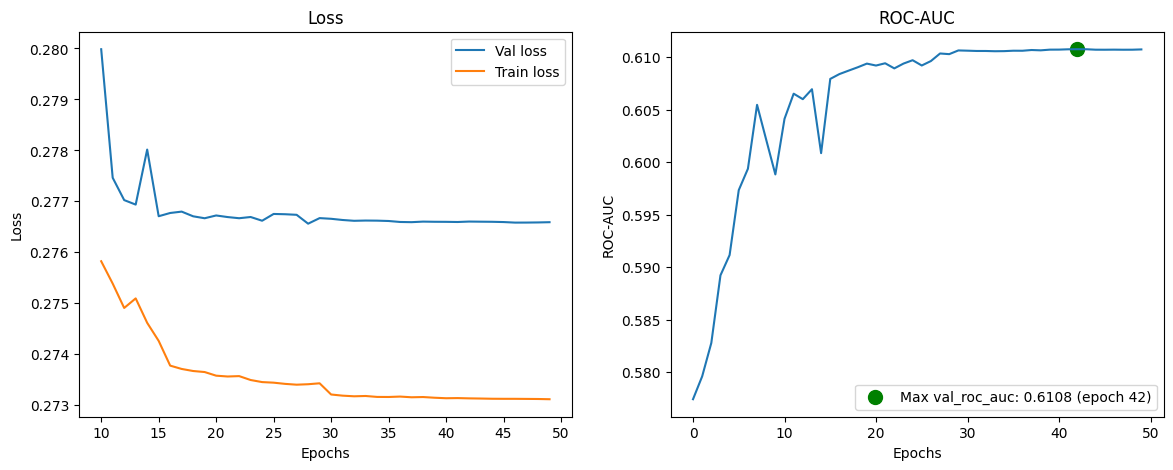

73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - auc: 0.6372 - loss: 0.2710 - val_auc: 0.6101 - val_loss: 0.2766 - learning_rate: 1.0000e-04
577/577 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Validation ROC AUC score: 0.6107332644700348


In [32]:
from keras.metrics import AUC
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler

model2 = build_model2(train_x.shape[1],train_x.shape[2])
model2.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 0.02), metrics=[AUC(name='auc')])

ival = IntervalEvaluation(validation_data=(train_x_val, train_y_val.values), interval=1)
lr_scheduler = LearningRateScheduler(scheduler)

model2.fit(train_x_train, train_y_train,
          validation_data=(train_x_val, train_y_val.values),
          epochs=50, batch_size=1024,
          callbacks=[ival, lr_scheduler], verbose=1)

# Оценка модели на валидационной выборке
val_predictions = model2.predict(train_x_val)[:, 0]
val_score = roc_auc_score(train_y_val, val_predictions)
print('Validation ROC AUC score:', val_score)

In [41]:
def build_model_lstm(time_step, n_features):
    model = Sequential()
#     model.add(GRU(8, input_shape=(time_step, n_features), return_sequences=True))
#     model.add(GRU(4))
    model.add(LSTM(8, input_shape=(time_step, n_features)))
#     model.add(Dense(4, activation='relu'))
#     model.add(Dropout(0.7))
    model.add(Dense(1,activation='sigmoid'))
    return model

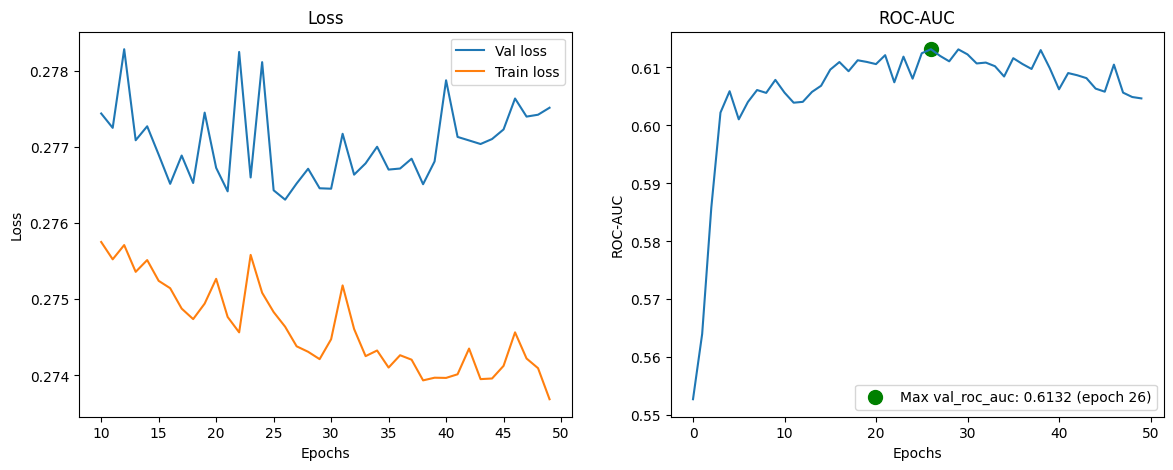

73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - auc: 0.6243 - loss: 0.2726 - val_auc: 0.6046 - val_loss: 0.2775
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Validation ROC AUC score: 0.6046682912013843


In [42]:
from keras.metrics import AUC
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler

model_lstm = build_model_lstm(train_x.shape[1],train_x.shape[2])
model_lstm.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 0.02), metrics=[AUC(name='auc')])

ival = IntervalEvaluation(validation_data=(train_x_val, train_y_val.values), interval=1)
lr_scheduler = LearningRateScheduler(scheduler)

model_lstm.fit(train_x_train, train_y_train,
          validation_data=(train_x_val, train_y_val.values),
          epochs=50, batch_size=1024,
          callbacks=[ival], verbose=1) # lr_scheduler

# Оценка модели на валидационной выборке
val_predictions = model_lstm.predict(train_x_val)[:, 0]
val_score = roc_auc_score(train_y_val, val_predictions)
print('Validation ROC AUC score:', val_score)

In [46]:
def build_model_rnn(time_step, n_features):
    model = Sequential()
#     model.add(GRU(8, input_shape=(time_step, n_features), return_sequences=True))
#     model.add(GRU(4))
    model.add(SimpleRNN(8, input_shape=(time_step, n_features)))
#     model.add(Dense(4, activation='relu'))
#     model.add(Dropout(0.7))
    model.add(Dense(1,activation='sigmoid'))
    return model

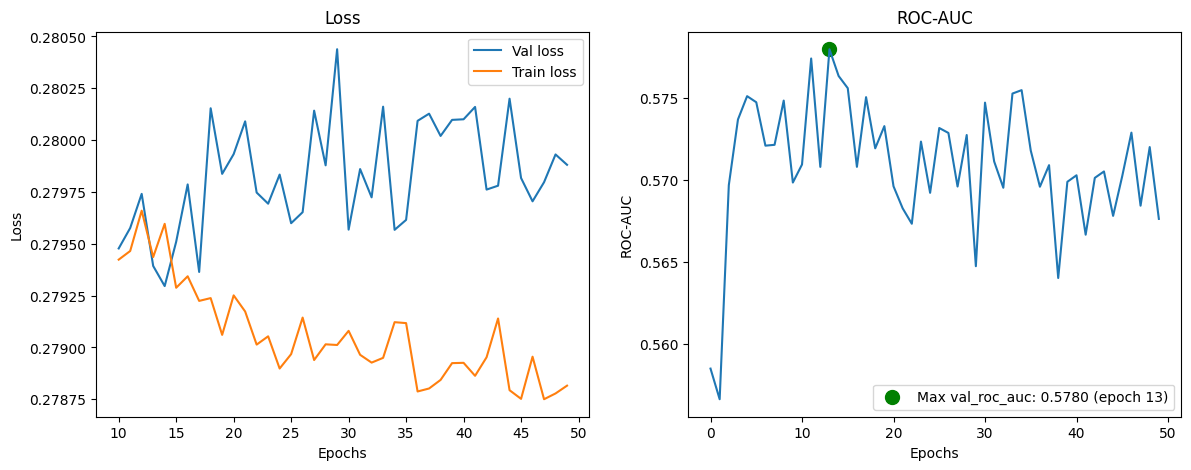

73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - auc: 0.5784 - loss: 0.2801 - val_auc: 0.5654 - val_loss: 0.2799
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Validation ROC AUC score: 0.567615030063191


In [48]:
from keras.metrics import AUC
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler

model_rnn = build_model_rnn(train_x.shape[1],train_x.shape[2])
model_rnn.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 0.01), metrics=[AUC(name='auc')])

ival = IntervalEvaluation(validation_data=(train_x_val, train_y_val.values), interval=1)
lr_scheduler = LearningRateScheduler(scheduler)

model_rnn.fit(train_x_train, train_y_train,
          validation_data=(train_x_val, train_y_val.values),
          epochs=50, batch_size=1024,
          callbacks=[ival], verbose=1) # lr_scheduler

# Оценка модели на валидационной выборке
val_predictions = model_rnn.predict(train_x_val)[:, 0]
val_score = roc_auc_score(train_y_val, val_predictions)
print('Validation ROC AUC score:', val_score)

In [59]:
recalls[10:-10]
# np.argmax(recalls)
# thresholds[np.argmax(precisions[:-1]) - 1]

array([1.        , 1.        , 1.        , ..., 0.00133156, 0.00133156,
       0.00133156])

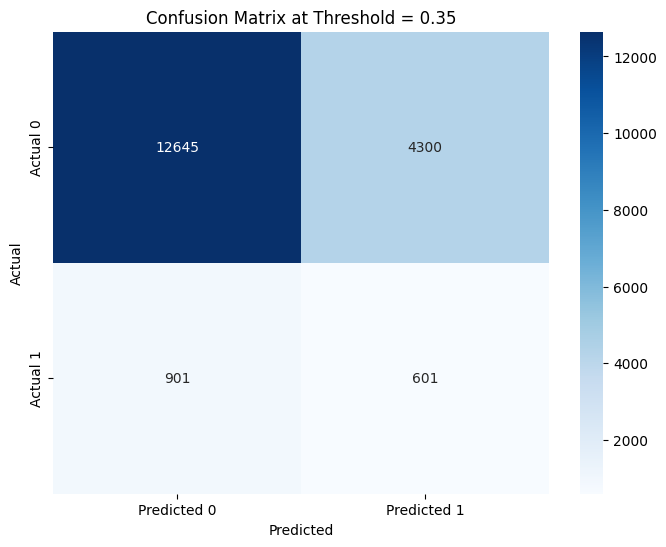

Optimal Threshold: 0.3548559844493866
Precision: 0.1226280350948786
Recall: 0.400133155792277


In [69]:
from sklearn.metrics import precision_recall_curve, confusion_matrix, precision_score, recall_score, auc, average_precision_score
import seaborn as sns

precisions, recalls, thresholds = precision_recall_curve(train_y_val, val_predictions)

# optimal_idx = np.argmax(recalls)
# optimal_threshold = thresholds[optimal_idx - 1]

best_threshold = None
best_diff = float('inf')
target_precision = 0.4
target_recall = 0.4

for precision, recall, threshold in zip(precisions, recalls, thresholds):
    diff = abs(precision - target_precision) + abs(recall - target_recall)
    if diff < best_diff:
        best_diff = diff
        best_threshold = threshold

y_pred = (val_predictions >= best_threshold).astype(int)

cm = confusion_matrix(train_y_val, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix at Threshold = {optimal_threshold:.2f}')
plt.show()

# Печать значений precision и recall для выбранного порога
print(f'Optimal Threshold: {optimal_threshold}')
print(f'Precision: {precision_score(train_y_val, y_pred)}')
print(f'Recall: {recall_score(train_y_val, y_pred)}')

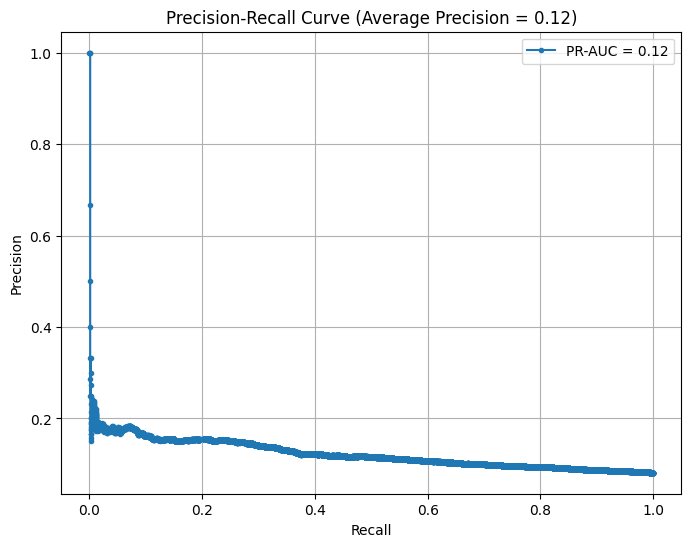

In [70]:
precisions, recalls, thresholds = precision_recall_curve(train_y_val, val_predictions)

# Вычисляем площадь под кривой (PR-AUC)
pr_auc = auc(recalls, precisions)

# Вычисляем среднюю точность
average_precision = average_precision_score(train_y_val, val_predictions)

# Построение PR кривой
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, marker='.', label=f'PR-AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (Average Precision = {average_precision:.2f})')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
model = build_model(train2_x.shape[1],train2_x.shape[2])
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 0.002), metrics=[AUC(name='auc')])

ival = IntervalEvaluation(validation_data=(train2_x_val, train2_y_val.values), interval=1)
lr_scheduler = LearningRateScheduler(scheduler)

model.fit(train2_x_train, train2_y_train,
          validation_data=(train2_x_val, train2_y_val.values),
          epochs=150, batch_size=2048,
          callbacks=[ival, lr_scheduler], verbose=1)

# Оценка модели на валидационной выборке
val_predictions = model.predict(train2_x_val)[:, 0]
val_score = roc_auc_score(train2_y_val, val_predictions)
print('Validation ROC AUC score:', val_score)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


NameError: name 'AUC' is not defined

In [43]:
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import LSTM, GRU, SimpleRNN
from keras.regularizers import l2
from keras.optimizers import RMSprop, Adam

from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
import logging

def build_model(time_step, n_features):
    model = Sequential()
    model.add(GRU(4, input_shape=(time_step, n_features))) #unit: #of neurons in each LSTM cell? input_shape=(time_step, n_features)
    model.add(Dense(1,activation='sigmoid'))
    return model

In [ ]:
class IntervalEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == (self.interval-1):
            y_pred = self.model.predict(self.X_val, verbose=0)[:,0]
            score = roc_auc_score(self.y_val, y_pred)
            print('roc score',score)

In [ ]:
from IPython.display import clear_output

class IntervalEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()
        self.interval = interval
        self.X_val, self.y_val = validation_data
        self.epoch = []
        self.history = {'loss': [], 'val_loss': [], 'val_roc_auc': []}

    def on_epoch_end(self, epoch, logs={}):
        self.epoch.append(epoch)
        self.history['loss'].append(logs.get('loss'))
        self.history['val_loss'].append(logs.get('val_loss'))

        y_pred_val = self.model.predict(self.X_val, verbose=0)[:, 0]
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        self.history['val_roc_auc'].append(roc_val)
        
        print(f'epoch: {epoch + 1} - val_roc_auc: {roc_val:.4f}')

        self.plot_history()

    def plot_history(self):
        if len(self.epoch) > 1: 
            clear_output()
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

            # Plot loss
            ax1.plot(self.epoch, self.history['loss'], label='Train loss')
            ax1.plot(self.epoch, self.history['val_loss'], label='Val loss')
            ax1.set_title('Loss')
            ax1.set_xlabel('Epochs')
            ax1.set_ylabel('Loss')
            ax1.set_ylim(0.2, 0.35)
            ax1.legend()

            # Plot ROC AUC
            ax2.plot(self.epoch, self.history['val_roc_auc'])
            ax2.set_title('ROC-AUC')
            ax2.set_xlabel('Epochs')
            ax2.set_ylabel('ROC-AUC')
            plt.show()
            
            if len(self.epoch) == self.params['epochs']:
                fig.savefig('training_history.png')

In [ ]:
from sklearn.model_selection import train_test_split

train_x_train, train_x_val, train_y_train, train_y_val = train_test_split(
    train_x, train_y, test_size=0.2, random_state=42, stratify=train_y)

In [ ]:
train_y.values

In [ ]:
from keras.metrics import AUC
import matplotlib.pyplot as plt

model2 = build_model(train_x.shape[1],train_x.shape[2])
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=[AUC(name='auc')])

ival = IntervalEvaluation(validation_data=(train_x_val, train_y_val.values), interval=1)
model2.fit(train_x_train, train_y_train,
          validation_data=(train_x_val, train_y_val.values),
          epochs=250, batch_size=1024,
          callbacks=[ival], verbose=1)

# Оценка модели на валидационной выборке
val_predictions = model.predict(train_x_val)[:, 0]
val_score = roc_auc_score(train_y_val, val_predictions)
print('Validation ROC AUC score:', val_score)

In [ ]:
def build_model2(time_step, n_features):
    model = Sequential()
    model.add(GRU(8, input_shape=(time_step, n_features)))
    model.add(Dense(1,activation='sigmoid'))
    return model

In [ ]:
model2 = build_model2(train_x.shape[1],train_x.shape[2])
model2.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=[AUC(name='auc')])

ival = IntervalEvaluation(validation_data=(train_x_val, train_y_val.values), interval=1)
model2.fit(train_x_train, train_y_train,
          validation_data=(train_x_val, train_y_val.values),
          epochs=200, batch_size=1024,
          callbacks=[ival], verbose=1)

# Оценка модели на валидационной выборке
val_predictions = model.predict(train_x_val)[:, 0]
val_score = roc_auc_score(train_y_val, val_predictions)
print('Validation ROC AUC score:', val_score)

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# model.summary()

### Main

In [71]:
df = pd.read_csv('/kaggle/input/cleaned-train-csv/cleaned_train.csv')
df.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,1.000000
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,0.006402,0.007,0.034362,0.267395,0.265474,1.899974
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000


In [72]:
new_numeric_columns = ['SK_ID_CURR', 'AMT_ANNUITY', 'AMT_CREDIT', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 
                       'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION',   'EXT_SOURCE_1', 
                       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'FLAG_DOCUMENT_3', 'HOUR_APPR_PROCESS_START', 
                       'LANDAREA_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAREA_AVG', 'REGION_POPULATION_RELATIVE', 
                       'REG_CITY_NOT_WORK_CITY', 'YEARS_BEGINEXPLUATATION_AVG', 'TARGET']

cols = new_numeric_columns + list(df.loc[:, df.dtypes==object].columns)
df = df[cols]

In [75]:
0.2 - val_df_bur.shape[0] / other_df.shape[0]

0.16377556350059477

In [134]:
train_y.iloc[val_idx].index.to_list()
1

1

In [141]:
X_val_buro

,SK_ID_CURR,AMT_ANNUITY,AMT_CREDIT,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,EXT_SOURCE_1,EXT_SOURCE_2,...,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
25,100030,11074.5,225000.0,-19334,-3494,-2893,0.0,-2419.0,0.561948,0.651406,...,Secondary / secondary special,Married,House / apartment,Cleaning staff,SATURDAY,Business Entity Type 3,reg oper account,block of flats,"Stone, brick",No
27,100032,23827.5,327024.0,-15948,-1234,-3153,-2.0,-5782.0,0.502130,0.541124,...,Secondary / secondary special,Married,House / apartment,Laborers,SATURDAY,Industry: type 11,NEW,NEW,NEW,NEW
48,100055,37255.5,1350000.0,-19727,-4411,-3199,-784.0,-6225.0,0.710427,0.589187,...,Secondary / secondary special,Married,House / apartment,Managers,THURSDAY,Government,NEW,NEW,NEW,NEW
141,100163,19773.0,550489.5,-19718,-5717,-3200,-1691.0,-8940.0,0.656938,0.390993,...,Higher education,Separated,House / apartment,NEW,FRIDAY,Other,NEW,NEW,NEW,NEW
161,100190,24781.5,263686.5,-13972,-4472,-4529,-1161.0,-464.0,0.534999,0.585859,...,Higher education,Married,House / apartment,Laborers,THURSDAY,Government,reg oper account,block of flats,Panel,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178995,307422,33682.5,657166.5,-16396,-2517,-6072,-1421.0,-10516.0,0.423629,0.637270,...,Secondary / secondary special,Separated,Municipal apartment,Sales staff,SATURDAY,Business Entity Type 3,NEW,NEW,NEW,NEW
178996,307423,7875.0,157500.0,-14635,-3876,-4469,-143.0,-1469.0,0.225704,0.676385,...,Higher education,Married,House / apartment,NEW,TUESDAY,Construction,NEW,block of flats,NEW,No
179011,307442,13594.5,225000.0,-11028,-1328,-781,-1903.0,-11004.0,0.349980,0.495874,...,Secondary / secondary special,Married,House / apartment,Cooking staff,MONDAY,Self-employed,NEW,NEW,NEW,NEW
179050,307482,35937.0,592560.0,-11877,-602,-2542,-465.0,-5370.0,0.622999,0.524109,...,Secondary / secondary special,Married,House / apartment,Cooking staff,SATURDAY,Self-employed,NEW,block of flats,Panel,No


In [154]:
val_df_bur

,SK_ID_CURR,AMT_ANNUITY,AMT_CREDIT,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,EXT_SOURCE_1,EXT_SOURCE_2,...,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
25,100030,11074.5,225000.0,-19334,-3494,-2893,0.0,-2419.0,0.561948,0.651406,...,Secondary / secondary special,Married,House / apartment,Cleaning staff,SATURDAY,Business Entity Type 3,reg oper account,block of flats,"Stone, brick",No
27,100032,23827.5,327024.0,-15948,-1234,-3153,-2.0,-5782.0,0.502130,0.541124,...,Secondary / secondary special,Married,House / apartment,Laborers,SATURDAY,Industry: type 11,NEW,NEW,NEW,NEW
48,100055,37255.5,1350000.0,-19727,-4411,-3199,-784.0,-6225.0,0.710427,0.589187,...,Secondary / secondary special,Married,House / apartment,Managers,THURSDAY,Government,NEW,NEW,NEW,NEW
141,100163,19773.0,550489.5,-19718,-5717,-3200,-1691.0,-8940.0,0.656938,0.390993,...,Higher education,Separated,House / apartment,NEW,FRIDAY,Other,NEW,NEW,NEW,NEW
161,100190,24781.5,263686.5,-13972,-4472,-4529,-1161.0,-464.0,0.534999,0.585859,...,Higher education,Married,House / apartment,Laborers,THURSDAY,Government,reg oper account,block of flats,Panel,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178995,307422,33682.5,657166.5,-16396,-2517,-6072,-1421.0,-10516.0,0.423629,0.637270,...,Secondary / secondary special,Separated,Municipal apartment,Sales staff,SATURDAY,Business Entity Type 3,NEW,NEW,NEW,NEW
178996,307423,7875.0,157500.0,-14635,-3876,-4469,-143.0,-1469.0,0.225704,0.676385,...,Higher education,Married,House / apartment,NEW,TUESDAY,Construction,NEW,block of flats,NEW,No
179011,307442,13594.5,225000.0,-11028,-1328,-781,-1903.0,-11004.0,0.349980,0.495874,...,Secondary / secondary special,Married,House / apartment,Cooking staff,MONDAY,Self-employed,NEW,NEW,NEW,NEW
179050,307482,35937.0,592560.0,-11877,-602,-2542,-465.0,-5370.0,0.622999,0.524109,...,Secondary / secondary special,Married,House / apartment,Cooking staff,SATURDAY,Self-employed,NEW,block of flats,Panel,No


In [183]:
train_y.iloc[val_idx]

,TARGET
SK_ID_CURR,
212082,0
321421,0
180667,0
160453,0
297232,0
...,...
341085,0
355085,0
137140,0


In [224]:
val_df_bur.shape

(18447, 36)

In [223]:
other_df = df[~df['SK_ID_CURR'].isin(train_y.iloc[val_idx].index.to_list())]
val_df_bur = df[df['SK_ID_CURR'].isin(train_y.iloc[val_idx].index.to_list())]

X = other_df.drop('TARGET', axis=1)
y = other_df['TARGET']

X_val_buro = val_df_bur.drop('TARGET', axis=1)
y_val_buro = val_df_bur['TARGET']

X_train, X_val_part, y_train, y_val_part = train_test_split(X, y, test_size=0.14, 
                                                    random_state=42, stratify=y)

Проверка:

In [225]:
y_val = pd.concat([y_val_part, y_val_buro], ignore_index=False)
X_val = pd.concat([X_val_part, X_val_buro], ignore_index=True)

X_val

,SK_ID_CURR,AMT_ANNUITY,AMT_CREDIT,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,EXT_SOURCE_1,EXT_SOURCE_2,...,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,190393,14872.5,391090.5,-19269,-4188,-2789,-1776.0,-2700.0,0.861546,0.254760,...,Secondary / secondary special,Civil marriage,House / apartment,Sales staff,MONDAY,Self-employed,NEW,NEW,NEW,NEW
1,236356,21001.5,647046.0,-15966,-7086,-4930,-1768.0,-1427.0,0.772461,0.595549,...,Higher education,Married,House / apartment,Managers,MONDAY,School,reg oper account,block of flats,Panel,No
2,229307,22972.5,518562.0,-16613,-1329,-167,-161.0,-2058.0,0.427747,0.484262,...,Secondary / secondary special,Married,Municipal apartment,Laborers,TUESDAY,Business Entity Type 1,NEW,NEW,NEW,No
3,432998,53118.0,1528200.0,-16292,-8827,-4438,-1510.0,-8848.0,0.657466,0.658438,...,Secondary / secondary special,Married,House / apartment,Laborers,FRIDAY,Business Entity Type 2,NEW,block of flats,Panel,No
4,129296,36459.0,755190.0,-19323,-11114,-2527,-1269.0,-13434.0,0.502130,0.746130,...,Higher education,Married,House / apartment,NEW,THURSDAY,Military,reg oper account,block of flats,Panel,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58911,456156,7632.0,119448.0,-18324,-1127,-1855,-1366.0,-9807.0,0.323674,0.134254,...,Secondary / secondary special,Single / not married,House / apartment,NEW,WEDNESDAY,Transport: type 4,NEW,block of flats,Panel,No
58912,456180,9580.5,90000.0,-15921,-2175,-4242,-1406.0,-6233.0,0.541523,0.511092,...,Secondary / secondary special,Married,House / apartment,Managers,FRIDAY,Emergency,NEW,NEW,NEW,NEW
58913,456226,34969.5,500566.5,-14106,-226,-933,-611.0,-2463.0,0.470808,0.737905,...,Secondary / secondary special,Married,House / apartment,Managers,THURSDAY,Telecom,not specified,block of flats,Block,No
58914,456247,17770.5,345510.0,-11870,-399,-3936,-2315.0,-675.0,0.243466,0.501221,...,Higher education,Single / not married,House / apartment,Core staff,SATURDAY,Bank,NEW,NEW,NEW,NEW


In [77]:
y_val

284665    0
219825    0
91349     0
258342    0
40567     0
         ..
178995    0
178996    0
179011    0
179050    0
179067    1
Name: TARGET, Length: 59508, dtype: int64

In [226]:
X_val = X_val.drop('SK_ID_CURR', axis=1)
X_train = X_train.drop('SK_ID_CURR', axis=1)

In [198]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from category_encoders import WOEEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, recall_score, accuracy_score, precision_score

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [227]:
numeric_columns = X_train.loc[:, X_train.dtypes!=object].columns
object_columns = X_train.loc[:, X_train.dtypes==object].columns
    
column_transformer = ColumnTransformer([
    ('woe', WOEEncoder(), object_columns),  
    ('scaling', StandardScaler(), numeric_columns)
])

X_train_transform = column_transformer.fit_transform(X_train, y_train)
X_val_transform = column_transformer.transform(X_val) 

In [24]:
def scheduler(epoch, lr):
    if epoch == 15 or epoch == 30:
        return lr * 0.1
    elif epoch == 40:
        return lr * 0.5
    return lr

In [81]:
def build_model3(n_features):
#     model = Sequential()
#     model.add(GRU(4, input_shape=(time_step, n_features))) #unit: #of neurons in each LSTM cell? input_shape=(time_step, n_features)
#     model.add(Dense(1,activation='sigmoid'))
    model = Sequential()
    model.add(Dense(16, input_dim=34, activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.9))

    # Второй скрытый слой с нормализацией
    model.add(Dense(8, activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.9))

    # Третий скрытый слой с нормализацией
    model.add(Dense(4, activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.9))


    model.add(Dense(1, activation='sigmoid'))
    return model

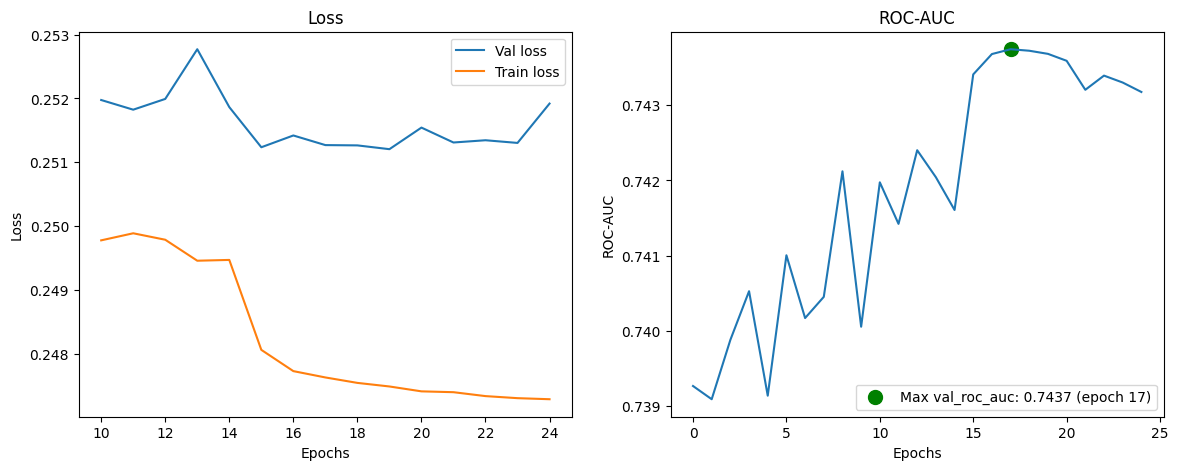

486/486 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - auc: 0.7558 - loss: 0.2437 - val_auc: 0.7432 - val_loss: 0.2519 - learning_rate: 0.0020
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Validation ROC AUC score: 0.7431785051621019


In [228]:
model = build_model3(train_x.shape[1])
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.02), metrics=[AUC(name='auc')])

lr_scheduler = LearningRateScheduler(scheduler)
ival = IntervalEvaluation(validation_data=(X_val_transform, y_val.values), interval=1)
model.fit(X_train_transform, y_train.values,
          validation_data=(X_val_transform, y_val.values),
          epochs=25, batch_size=512, shuffle=True,
          callbacks=[ival, lr_scheduler], verbose=1)

# Оценка модели на валидационной выборке
val_predictions = model.predict(X_val_transform)[:, 0]
val_score = roc_auc_score(y_val, val_predictions)
print('Validation ROC AUC score:', val_score)

In [ ]:
sum(y_train) / len(y_train), sum(y_val) / len(y_val)

In [ ]:
model = build_model3(train_x.shape[1])
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.02), metrics=[AUC(name='auc')])

lr_scheduler = LearningRateScheduler(scheduler)
ival = IntervalEvaluation(validation_data=(X_val_transform, y_val.values), interval=1)
model.fit(X_train_transform, y_train.values,
          validation_data=(X_val_transform, y_val.values),
          epochs=40, batch_size=2048, shuffle=True,
          callbacks=[ival, lr_scheduler], verbose=1)

# Оценка модели на валидационной выборке
val_predictions = model.predict(X_val_transform)[:, 0]
val_score = roc_auc_score(y_val, val_predictions)
print('Validation ROC AUC score:', val_score)

In [85]:
val_predictions = model.predict(X_val_transform)[:, 0]
val_score = roc_auc_score(y_val, val_predictions)

1860/1860 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [146]:
y_val_buro.values

array([0, 0, 0, ..., 0, 0, 1])

In [229]:
main_val = pd.DataFrame({'main':model.predict(X_val_transform[-(X_val_buro.shape[0]):, :])[:, 0],
                        'target' : y_val_buro.values}, 
                        index=X_val_buro['SK_ID_CURR'])
# main_test = pd.DataFrame({'main':model.predict(X_val_transform)[:, 0]}, index=test_id)             
main_val

577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


,main,target
SK_ID_CURR,,
100032,0.125595,0
100048,0.407240,0
100060,0.033212,0
100063,0.125396,0
100064,0.131058,0
...,...,...
456156,0.136059,0
456180,0.020760,0
456226,0.040174,0


In [230]:
roc_auc_score(main_val['target'], main_val['main'])

0.7364900502487292

In [142]:
X_val_transform[len(val_idx):, :].shape,X_val_transform[:len(val_idx), :].shape

X_val_transform[-(X_val_buro.shape[0]):, :].shape, X_val_transform[:-(X_val_buro.shape[0]), :].shape

((10750, 34), (48758, 34))

In [124]:
temp_table = pd.DataFrame({'main':model.predict(X_val_transform[len(val_idx):, :])[:, 0],
             'TARGET':y_val[len(val_idx):]})

roc_auc_score(temp_table['TARGET'], temp_table['main'])

1284/1284 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


0.7471413025903988

In [116]:
temp_table

,main,TARGET
284768,0.018035,0
63195,0.017581,1
13968,0.067183,0
224755,0.046260,0
183392,0.087169,0
...,...,...
178995,0.083709,0
178996,0.021416,0
179011,0.053784,0
179050,0.121719,0


In [152]:
len(train_x_val)

18447

In [231]:
buro_val = pd.DataFrame({'buro':model2.predict(train_x_val)[:, 0]}, index=train_y.iloc[val_idx].index)
# main_test = pd.DataFrame({'main':model.predict(X_val_transform)[:, 0]}, index=test_id)             
buro_val

577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


,buro
SK_ID_CURR,
212082,0.074301
321421,0.073779
180667,0.043608
160453,0.052269
297232,0.085439
...,...
341085,0.046422
355085,0.046441
137140,0.055315


In [233]:
main_buro_val = buro_val.join(main_val).join(train_y)
main_buro_val

,buro,main,target,TARGET
SK_ID_CURR,,,,
212082,0.074301,0.153442,0,0
321421,0.073779,0.054453,0,0
180667,0.043608,0.007118,0,0
160453,0.052269,0.026961,0,0
297232,0.085439,0.087906,0,0
...,...,...,...,...
341085,0.046422,0.057326,0,0
355085,0.046441,0.025838,0,0
137140,0.055315,0.112315,0,0


In [234]:
sum(~main_buro_val['target'] == main_buro_val['TARGET'])

0

In [106]:
roc_auc_score(y_train, X_train['buro'])

0.612161705162489

In [ ]:
main_buro_val[main_buro_val['TARGET'] == 1]
main_buro_val['max_'] = main_buro_val[['buro', 'main']].max(axis=1)

In [ ]:
main_buro_val[main_buro_val['max_'] > 0.2]

In [ ]:
roc_auc_score(main_buro_val['TARGET'], main_buro_val['max_'].astype(int))

In [ ]:
train_y.iloc[val_idx]

In [235]:
X_train, X_test, y_train, y_test = train_test_split(main_buro_val.drop(['TARGET', 'target'], axis=1), 
                                                            main_buro_val['TARGET'], test_size=0.2, 
                                                    random_state=30, stratify=main_buro_val['TARGET'])

meta_model = LogisticRegression()
meta_model.fit(X_train, y_train)

final_predictions = meta_model.predict_proba(X_test)[:, 1] 

# Оценка мета-модели на тренировочных данных
roc_score = roc_auc_score(y_test, final_predictions)
print('Meta-model ROC AUC score:', roc_score)

Meta-model ROC AUC score: 0.7386951819075713


In [114]:
y_test

299882    0
78409     0
3315      0
284416    0
283146    0
         ..
11546     0
270996    0
109915    0
151710    0
234967    0
Name: TARGET, Length: 3690, dtype: int64

In [118]:
togehter = pd.concat([pd.DataFrame({'main':final_predictions,
             'TARGET':y_test}, index=y_test.index), temp_table])

In [121]:
roc_auc_score(togehter['TARGET'], togehter['main'])

0.7389149055552828

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, (final_predictions > 0.4))